# Predicting Monthly Rent of NYC Apartments

##### Moorissa Tjokro (February 2017)

This site shows a simple process of building a machine learning algorithm to predict monthly rent fee for apartments across neighborhoods in New York City based on a government housing dataset in 2014.

*Data source: https://www.census.gov/housing/nychvs/data/2014/userinfo2.html*

In [1]:
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
plt.rcParams["figure.dpi"] = 100
np.set_printoptions(precision=3, suppress=True)
import pandas as pd

In [2]:
df = pd.read_csv("data.csv", na_values=[9999, 99999, 999999, 9999999])

In [3]:
df.head()

recid  boro  uf1_1  uf1_2  uf1_3  uf1_4  uf1_5  uf1_6  uf1_7  uf1_8  \
0      1     1      9      9      9      9      1      9      9      9   
1      1     1      9      9      9      9      1      9      9      9   
2      1     1      9      9      9      9      1      9      9      9   
3      1     1      9      9      9      9      1      9      9      9   
4      1     1      9      9      9      9      1      9      9      9   

    ...     hflag4  hflag18  uf52h_h  uf52h_a  uf52h_b  uf52h_c  uf52h_d  \
0   ...          0        0        0        0        0        0        0   
1   ...          0        0        1        1        1        0        0   
2   ...          0        0        1        1        1        0        1   
3   ...          0        0        0        0        0        0        0   
4   ...          0        0        1        0        0        0        1   

   uf52h_e  uf52h_f  uf52h_g  
0        0        0        0  
1        0        0        0  
2        0        1        0  
3        0        0        0  
4        0        0        0  

[5 rows x 197 columns]

In [4]:
# selecting the response variable, uf17 is the "monthly contract rent" fee.
# take out datapoints with no rent fee records
no_rent = df.uf17.isnull() 

In [5]:
# available data points:
no_rent.value_counts()

False    10229
True      5113
Name: uf17, dtype: int64

In [6]:
df_rent = df[~no_rent]

In [7]:
# check the size of the dataset we're about to use:
df_rent.shape

(10229, 197)

In [8]:
# define your dependent (rent) and independent variables (data):
rent = df_rent.uf17
data = df_rent.drop("uf17", axis=1)
data = data.drop("race1", axis=1)  # really weirdly encoded, also we don't need it

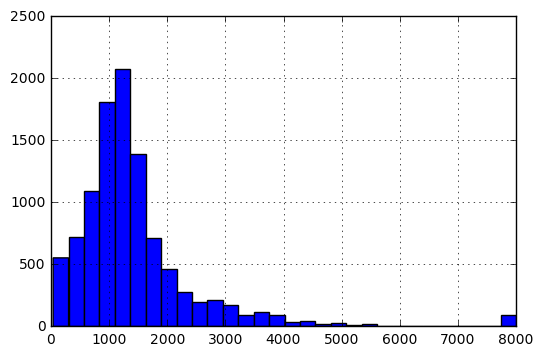

In [9]:
# check the distribution of the response variable to get a sense of our model:
rent.hist(bins=30)

In [10]:
# check the variance of the features (axis=0)
# take columns with variance > 0 because we're interested in datapoints that show patterns
non_const_columns = data.var(axis=0) > 0 # axis=0 indicates columns, while axis=1 indicates rows.

In [11]:
data_ = data[data.columns[non_const_columns]]

In [12]:
data_.shape

(10229, 174)

In [13]:
# now we split the data into training and test set for building the model
from sklearn.model_selection import train_test_split
data_train, data_test, rent_train, rent_test = train_test_split(data_, rent, random_state=1)

In [14]:
# checking the number of unique values in every column
counts = np.array([len(data_train[col].value_counts()) for col in data_train.columns])

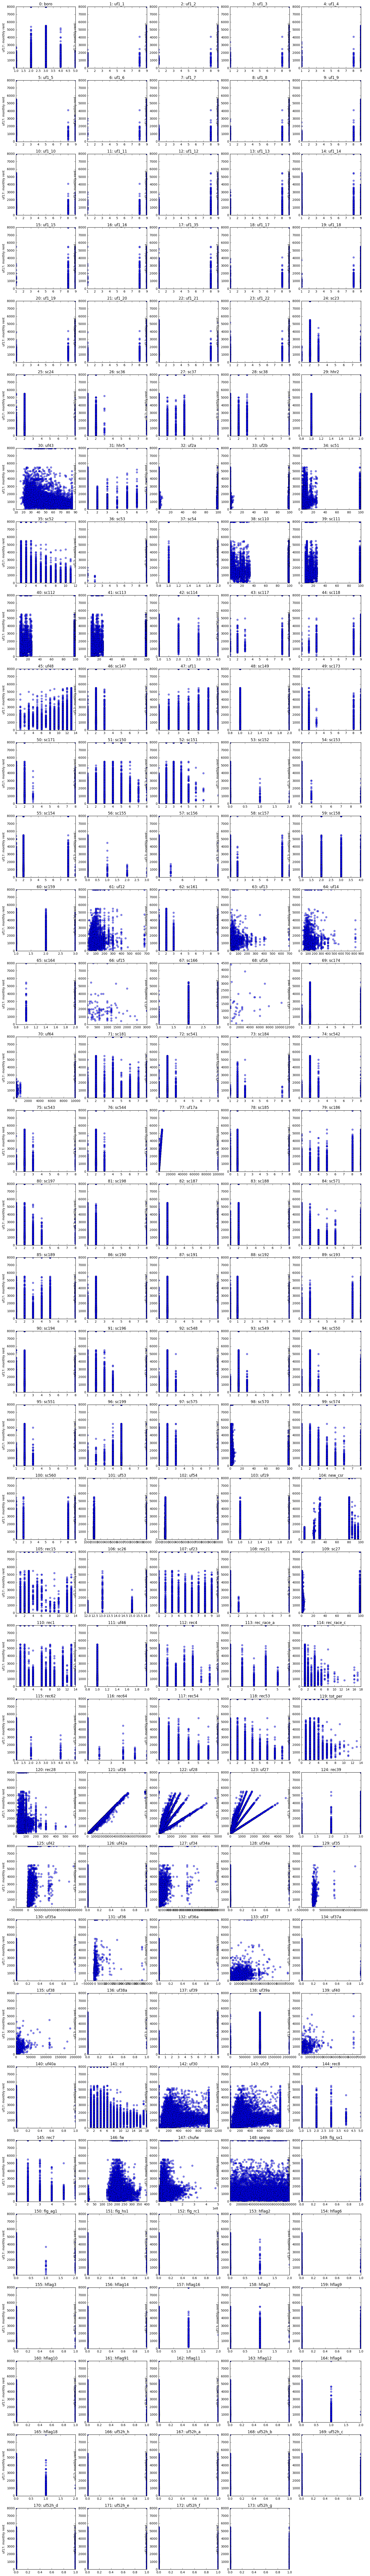

In [15]:
# we can also scatterplot the association between each independent variable and the response variable here:
fig, axes = plt.subplots(40, 5, figsize=(20, 170))
for i, ax in enumerate(axes.ravel()):
    if i > 173:
        ax.set_visible(False)
        continue
    ax.plot(np.asarray(data_train)[:, i], np.asarray(rent_train), 'o', alpha=.5)
    ax.set_title("{}: {}".format(i, data_train.columns[i]))
    ax.set_ylabel("uf17: monthly rent")

In [16]:
data_train[data_train.columns[counts > 10]].head()

uf43  sc51  sc52  sc110  sc111  sc112  sc113  uf48   uf12  uf13   ...    \
346     46     3     2     99     11     11     11    12    NaN   NaN   ...     
9064    24     6     1      1      7      7      7    12    NaN   NaN   ...     
897     41    11     2     99     11     11     11    11   90.0  36.0   ...     
4818    31     4     1      7     20     20     20     3    NaN   NaN   ...     
5223    57     4     4     99     12     12     12    12  115.0  25.0   ...     

      uf37  uf38   uf39a  uf40  cd    uf30    uf29         fw      chufw  \
346    NaN   NaN  999999   NaN   2   867.0   759.0  239.47278   99143898   
9064   NaN   NaN  999999   NaN   6   405.0   405.0  211.41603   41741961   
897    NaN   NaN  999999   NaN   5  1010.0  1010.0  225.35612   86950130   
4818   NaN   NaN  999999   NaN  13   103.0   103.0  179.96685  140526933   
5223   NaN   NaN  999999   NaN  14   274.0   243.0  172.53349   66491597   

       seqno  
346   255616  
9064   74796  
897   332736  
4818  622803  
5223  232986  

[5 rows x 41 columns]

In [17]:
# Taking variable names from the layout instead of using an encoded variable for each feature:

raw_variables = pd.read_excel("layout.xls", skiprows=4)
# drop repeats of the header
raw_variables = raw_variables[raw_variables['Variable Name'] != "Variable Name"]

variables = raw_variables.dropna(subset=['Variable Name'])

# sometimes two variable names correspond to the same item
# the first variable starts with rec and they are in directly adjacent rows
for i, row in variables.iterrows():
    if i - 1 in variables.index:
        # the row above also has a variable name
        row_above = variables.loc[i-1]
        if row_above['Variable Name'].startswith("REC"):
            # this is one of the culprits
            #print(row)
            #print(row_above)
            # replace UF row with REC row
            variables.loc[i]['Item Name'] = variables.loc[i-1]['Item Name']

mask = variables['Item Name'].isnull()
variables = variables.copy()  # variables is a slice of a dataframe and not a dataframe before this.
variables['Item Name'][mask] = variables['Code and Description'][mask]
variables['Variable Name'] = variables['Variable Name'].str.strip(",").replace("SEX/HHR2", "HHR2")

variables = variables.set_index(variables['Variable Name'].str.lower())
variables.loc['uf43']['Item Name'] = variables.loc['hhr3t']['Item Name'] # manual fix ...
item_name = variables['Item Name']

source_codes = raw_variables.dropna(subset=['Source Code']).copy()
source_codes['Source Code'] = source_codes['Source Code'].astype("str").str.lstrip("0")
source_codes = source_codes.drop_duplicates(subset=["Source Code"])
sc_reindex = source_codes.set_index("sc" + source_codes['Source Code'])

source_code_series = sc_reindex['Item Name']

In [18]:
feature_mapping = {}
for c in data_.columns:
    if c in item_name.index:
        feature_mapping[c] = c + " " + item_name.loc[c]
    elif c in source_code_series.index:
        feature_mapping[c] = c + " " + source_code_series.loc[c]
    else:
        print(c)
feature_mapping['seqno'] = "seqno"

seqno


In [19]:
feature_mapping

{'boro': u'boro Borough',
 'cd': u'cd Sub-borough Area',
 'chufw': u'chufw Aggregate Persons Weight',
 'flg_ag1': u"flg_ag1 Householder's age",
 'flg_hs1': u'flg_hs1 Householder of Spanish/Hispanic',
 'flg_rc1': u"flg_rc1 Householder's  Race",
 'flg_sx1': u"flg_sx1 Householder's sex",
 'fw': u'fw Household Weight',
 'hflag10': u'hflag10 Gas - Monthly Cost',
 'hflag11': u'hflag11 Water and Sewer - Yearly Cost',
 'hflag12': u'hflag12 Other Fuels - Yearly Cost',
 'hflag14': u'hflag14 Complete Plumbing Facilities',
 'hflag16': u'hflag16 Kitchen Facilities',
 'hflag18': u'hflag18 Monthly Rent Paid by Government',
 'hflag2': u'hflag2 Year Moved In',
 'hflag3': u'hflag3 Number of Rooms/Bedrooms',
 'hflag4': u'hflag4 Monthly Contract Rent',
 'hflag6': u'hflag6 Stories in Building',
 'hflag7': u'hflag7 Type of Heating Fuel',
 'hflag9': u'hflag9 Electricity - Monthly Cost',
 'hflag91': u'hflag91 Combined Gas/Electricity - Monthly Cost',
 'hhr2': u"hhr2 Householder's Sex",
 'hhr5': u'hhr5 Origin'

In [20]:
# renaming the axes and redefining the split files using new feature names
data_desc = data_.rename_axis(feature_mapping, axis=1)
data_train, data_test, rent_train, rent_test = train_test_split(data_desc, rent, random_state=1)

In [21]:
data_desc.head(5)

boro Borough  uf1_1 Condition of External Walls  \
3              1                                  9   
5              1                                  9   
10             1                                  9   
11             1                                  9   
14             1                                  9   

    uf1_2 Sloping or bulging outside walls  \
3                                        9   
5                                        9   
10                                       9   
11                                       9   
14                                       9   

    uf1_3 Major cracks in outside walls  \
3                                     9   
5                                     9   
10                                    9   
11                                    9   
14                                    9   

    uf1_4 Loose or hanging cornice, roofing, or other material  \
3                                                   9            
5                                                   9            
10                                                  9            
11                                                  9            
14                                                  9            

    uf1_5 None of these problems with walls  uf1_6 Unable to observe walls  \
3                                         1                              9   
5                                         1                              9   
10                                        1                              9   
11                                        1                              9   
14                                        1                              9   

    uf1_7 Condition of Windows  uf1_8 Rotten/loose window frames/sashes  \
3                            9                                        9   
5                            9                                        9   
10                           9                                        9   
11                           9                                        9   
14                           9                                        9   

    uf1_9 Boarded-up windows               ...                \
3                          9               ...                 
5                          9               ...                 
10                         9               ...                 
11                         9               ...                 
14                         9               ...                 

    hflag4 Monthly Contract Rent  hflag18 Monthly Rent Paid by Government  \
3                              0                                        0   
5                              0                                        0   
10                             0                                        0   
11                             0                                        0   
14                             2                                        2   

    uf52h_h Total Household Income Recode  \
3                                       0   
5                                       0   
10                                      0   
11                                      0   
14                                      1   

    uf52h_a Household Income from Wages, Salaries,  \
3                                                0   
5                                                0   
10                                               0   
11                                               0   
14                                               1   

    uf52h_b Household Income from Farm or Nonfarm  \
3                                               0   
5                                               0   
10                                              0   
11                                              0   
14                                              1   

    uf52h_c Household Income from Interest, Dividends,  \

In [22]:
counts

array([   5,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,
          3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,
          3,    3,    4,    3,    4,    5,    4,    2,   70,    7,    9,
          9,   27,   11,    3,    2,   35,   20,   20,   20,    4,    5,
          5,   13,    4,    7,    2,    5,    4,    8,    8,    3,    3,
          4,    4,    3,    4,    4,    3,  172,    4,  114,  144,    2,
         41,    3,   25,    3,   30,    8,    4,    5,    4,    4,    4,
       1326,    3,    6,    5,    3,    3,    3,    6,    6,    3,    3,
          3,    4,    3,    5,    4,    4,    4,    4,    6,    4,   11,
          7,    4,   72,   86,    2,   11,   12,    4,   10,    3,    6,
         12,    2,    8,    6,   13,    4,    5,    7,    9,   14,   49,
       1875, 1299,  943,    3, 2431,    2, 1007,    2,  151,    2,  110,
          2,  536,    2,  276,    2,    2,  181,  181,    2,   18,  920,
        897,    5,    6, 2232, 5267, 7671,    2,   

In [23]:
# see the top 40 features with the highest count of unique values
pd.Series(counts, index=data_desc.columns).sort_values(ascending=False)[:40]

seqno                                        7671
chufw Aggregate Persons Weight               5267
uf42 Total Household Income Recode           2431
fw Household Weight                          2232
uf26 Monthly Gross Rent                      1875
uf17a Out of Pocket Rent                     1326
uf28 Monthly Gross Rent per Room             1299
uf34 Household Income from Wages,            1007
uf27 Monthly Contract Rent Per                943
uf30 Monthly Gross Rent as Percent of         920
uf29 Monthly Contract Rent as                 897
uf37 Household Income from Social             536
uf38 Household Income from                    276
uf39a Income Flag                             181
uf40 Household Income from                    181
uf12 Monthly Cost                             172
uf35 Household Income from                    151
uf14 Combined Gas/Electricity                 144
uf13 Monthly Cost                             114
uf36 Household Income from Interest,          110


In [24]:
# dropping columns that have too many distinct values, in this case those with at least 20 distinct values
drop_continuous_etc = counts >= 20

data_discrete = data_desc.drop(data_desc.columns[drop_continuous_etc], axis=1) # axis=1 because we are dropping rows not columns.
data_train, data_test, rent_train, rent_test = train_test_split(data_discrete, rent, random_state=1)

In [25]:
data_discrete.shape

(10229, 142)

In [26]:
# for each feature, we check whether there is any field that is empty. In this case every feature has at least an element.
data_discrete.isnull().any().any()

False

In [27]:
# Estimate mutual information for a continuous target variable 
# for identifying dependency between independent variables and its response variable.
# Mutual information (MI) between two random variables is a non-negative value, 
# which measures the dependency between the variables. 
# It is equal to zero if and only if two random variables are independent, and higher values mean higher dependency.

from sklearn.feature_selection import mutual_info_regression
mi = mutual_info_regression(data_train, rent_train.values) # rent_train.values: file only has one feature
inds = np.argsort(mi) # returns indices of the feature in the dataset, in an ascending order based on mi values

//anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)


(0, 142)

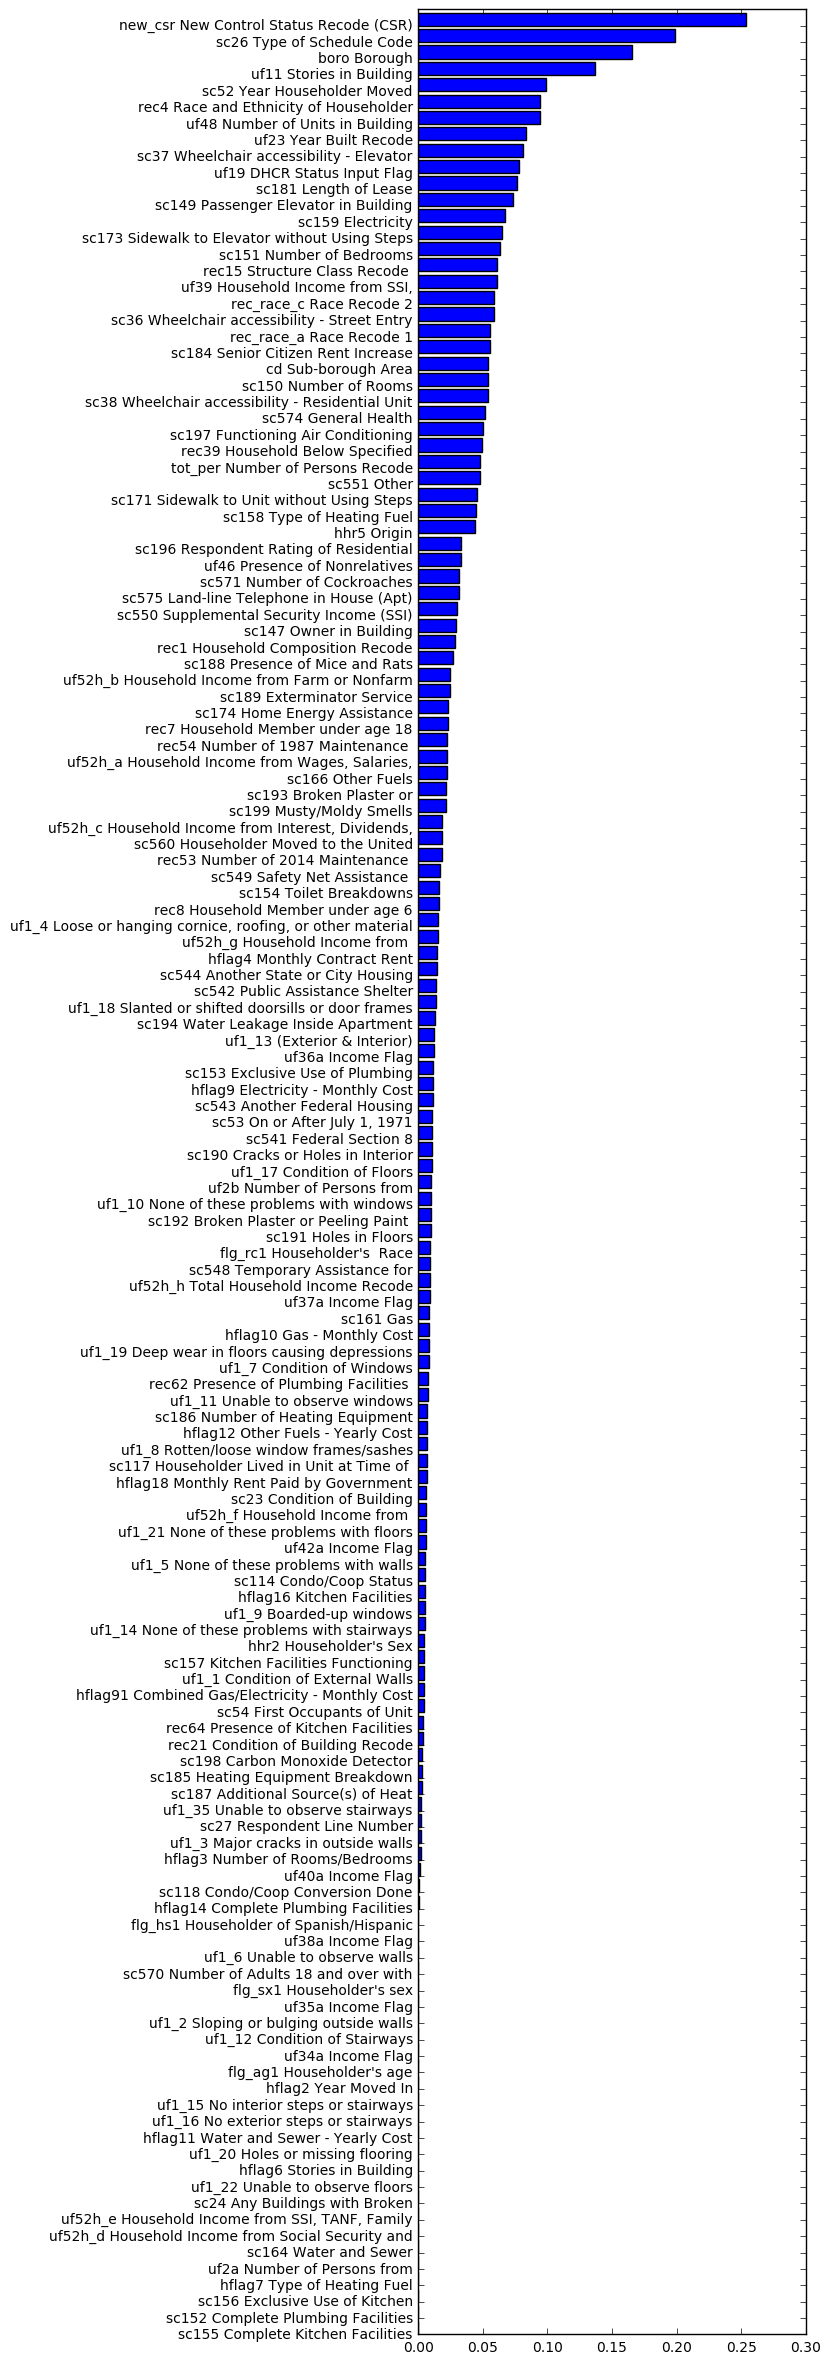

In [28]:
plt.figure(figsize=(5, 30))
plt.barh(np.arange(len(mi)), np.log(mi[inds] + 1))
plt.yticks(np.arange(len(mi)), data_train.columns[inds])
plt.ylim(0, len(mi))

In [29]:
def good_feature(x):
    bad_words = ["Household", "Rent", "Cost", "Race", "Moved In", "Origin", "sc5", "tot_per", "Lease"]
    for word in bad_words:
        if word in x:
            return False
    
    if x.startswith("uf") and not x.startswith("uf1"):
        return False
    
    return True
    
non_renter_columns = [x for x in data_train.columns if good_feature(x)]
len(non_renter_columns)

80

In [30]:
# features of the model we will be building on
# we only use features that apply to pricing an apartment that is not currently rented. 
sorted(non_renter_columns)

[u'boro Borough',
 u'cd Sub-borough Area',
 u'hflag14 Complete Plumbing Facilities',
 u'hflag16 Kitchen Facilities',
 u'hflag3 Number of Rooms/Bedrooms',
 u'hflag6 Stories in Building',
 u'hflag7 Type of Heating Fuel',
 u'new_csr New Control Status Recode (CSR)',
 u'rec15 Structure Class Recode ',
 u'rec21 Condition of Building Recode',
 u'rec53 Number of 2014 Maintenance ',
 u'rec54 Number of 1987 Maintenance ',
 u'rec62 Presence of Plumbing Facilities ',
 u'rec64 Presence of Kitchen Facilities',
 u'sc114 Condo/Coop Status',
 u'sc118 Condo/Coop Conversion Done',
 u'sc147 Owner in Building',
 u'sc149 Passenger Elevator in Building',
 u'sc150 Number of Rooms',
 u'sc151 Number of Bedrooms',
 u'sc152 Complete Plumbing Facilities',
 u'sc153 Exclusive Use of Plumbing',
 u'sc154 Toilet Breakdowns',
 u'sc155 Complete Kitchen Facilities',
 u'sc156 Exclusive Use of Kitchen',
 u'sc157 Kitchen Facilities Functioning',
 u'sc158 Type of Heating Fuel',
 u'sc159 Electricity',
 u'sc161 Gas',
 u'sc164 

In [31]:
data_non_renter = data_discrete[non_renter_columns]
data_train, data_test, rent_train, rent_test = train_test_split(data_non_renter, rent, random_state=1)

In [32]:
from sklearn.feature_selection import mutual_info_regression
mi = mutual_info_regression(data_train, rent_train)

(0, 80)

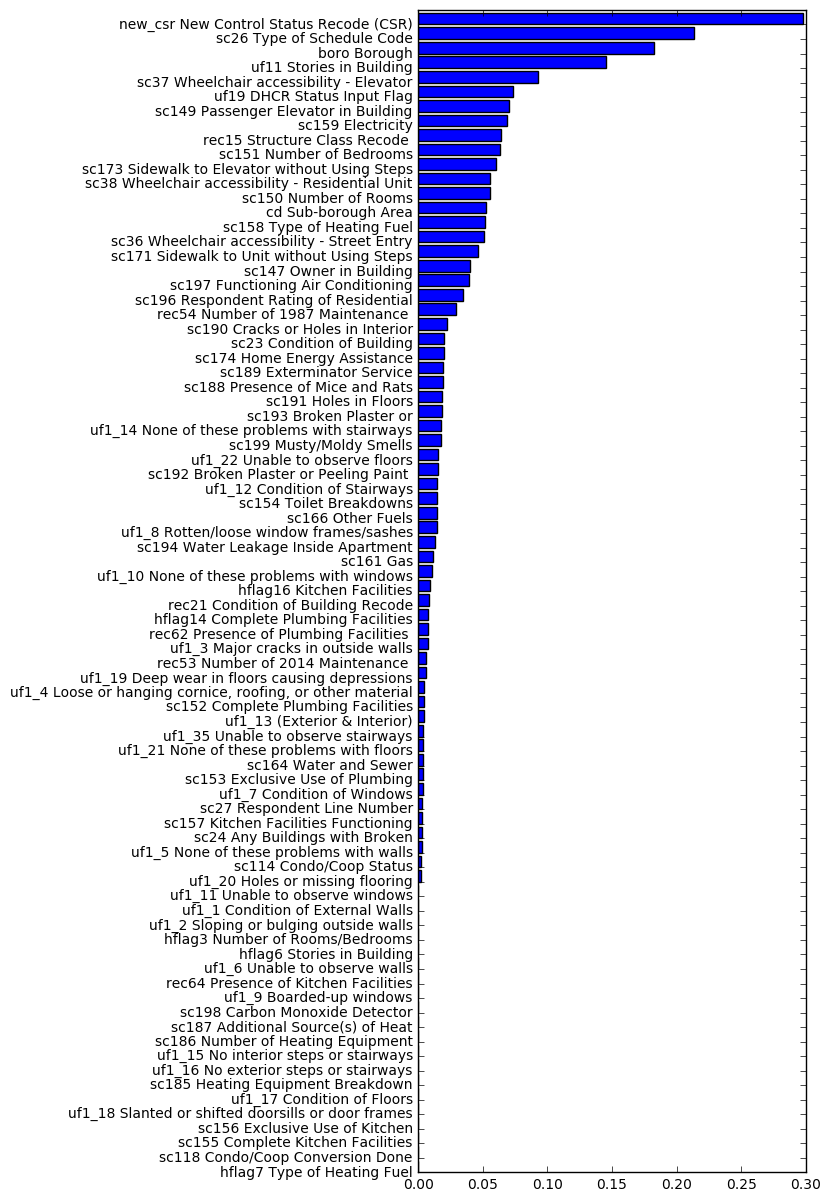

In [33]:
inds = np.argsort(mi)
plt.figure(figsize=(5, 15))
plt.barh(np.arange(len(mi)), mi[inds])
plt.yticks(np.arange(len(mi)), data_train.columns[inds])
plt.ylim(0, len(mi))

In [34]:
# Creating dummies for categorical variables
data_train_dummies = pd.get_dummies(data_train, columns=data_train.columns)

(0, 50)

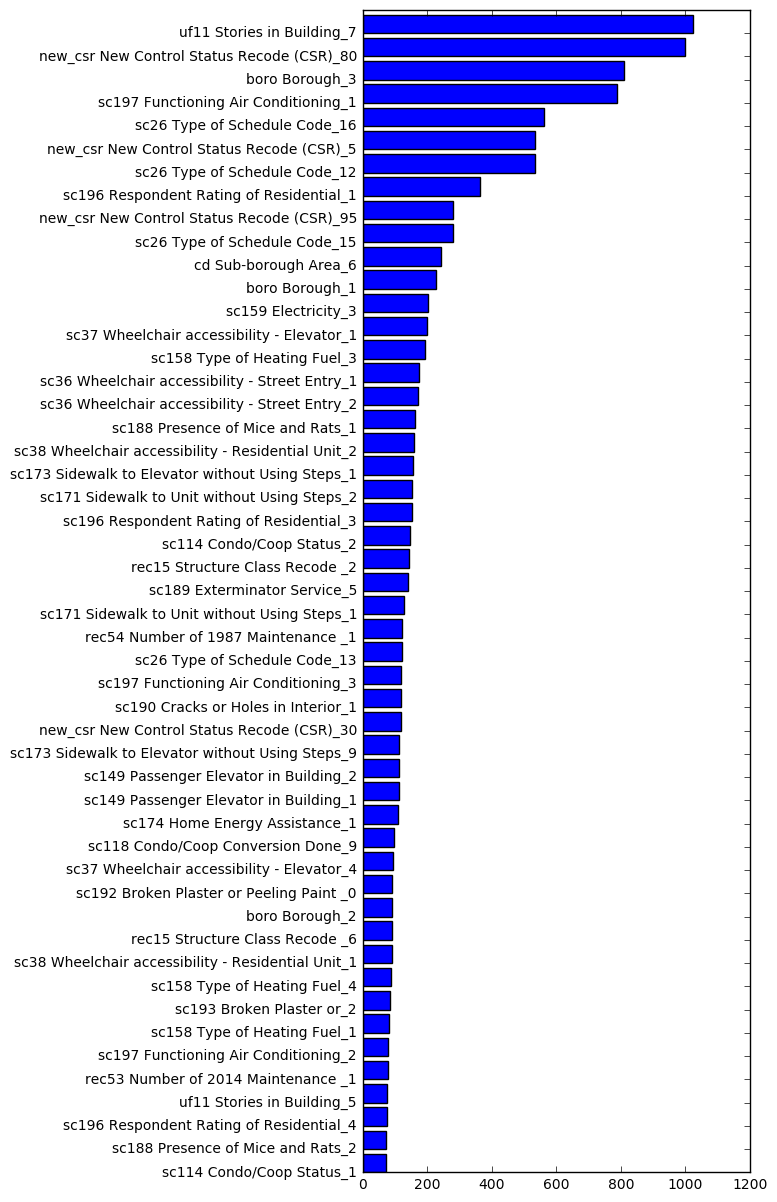

In [35]:
# Using f_regression to discard parameters
# meaning that we use a threshold to discard all features with too high a p-value 
# (which means they are unlikely to be related to the target).

from sklearn.feature_selection import f_regression
F, p = f_regression(data_train_dummies, rent_train)

top_n = 50
inds = np.argsort(F)
plt.figure(figsize=(5, 15))
plt.barh(np.arange(top_n), F[inds[-top_n:]])
plt.yticks(np.arange(top_n), data_train_dummies.columns[inds[-top_n:]])
plt.ylim(0, top_n)

In [36]:
# creating a pipeline using cross validation

from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_val_score

cross_val_score(RidgeCV(alphas=np.logspace(-3, 3, 7)), data_train_dummies, rent_train, cv=5)

array([ 0.491,  0.461,  0.533,  0.494,  0.513])

In [38]:
cross_val_score(RidgeCV(alphas=np.logspace(-3, 3, 7)), data_train_dummies, rent_train, cv=5).mean()

0.49826051633015817

In [39]:
ridge = RidgeCV(alphas=np.logspace(-3, 3, 7)).fit(data_train_dummies, rent_train)
ridge.alpha_

10.0

(0, 50)

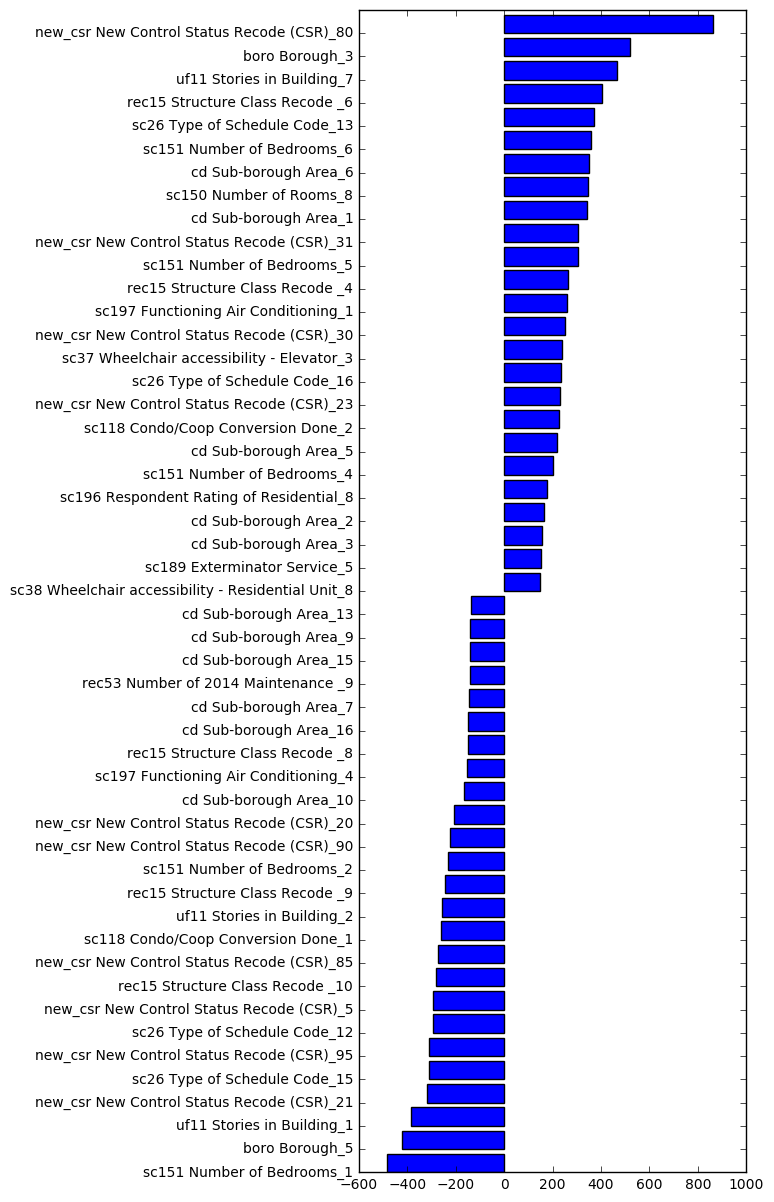

In [40]:
top_n = 50
coef = ridge.coef_
inds = np.argsort(coef)
inds = np.hstack([inds[:top_n // 2], inds[-top_n//2:]])
plt.figure(figsize=(5, 15))
plt.barh(np.arange(top_n), coef[inds])
plt.yticks(np.arange(top_n), data_train_dummies.columns[inds])
plt.ylim(0, top_n)

In [41]:
data_train_dummies.columns[inds[-1]]

u'new_csr New Control Status Recode (CSR)_80'

In [42]:
data_train["new_csr New Control Status Recode (CSR)"].value_counts()

80    2766
30    2640
31     917
5      633
95     316
85     169
21     116
90      96
20       8
23       7
22       3
Name: new_csr New Control Status Recode (CSR), dtype: int64

In [43]:
codes = """01=Owner occupied conventional
02=Owner occupied private cooperative
05=Public housing
12=Owner occupied condo
20=Article 4 or 5 building
21=HUD regulated
22=Loft Board regulated building
23=Municipal Loan Program
30=Stabilized pre 1947
31=Stabilized post 1947
80=Other rental
85=Mitchell Lama rental
86=Mitchell Lama cooperative
87=Mitchell Lama type cooperative
90=Controlled
95=In Rem"""

In [44]:
code_dict = {int(code.split("=")[0]): code.split("=")[1] for code in codes.split("\n")}
code_dict

{1: 'Owner occupied conventional',
 2: 'Owner occupied private cooperative',
 5: 'Public housing',
 12: 'Owner occupied condo',
 20: 'Article 4 or 5 building',
 21: 'HUD regulated',
 22: 'Loft Board regulated building',
 23: 'Municipal Loan Program',
 30: 'Stabilized pre 1947',
 31: 'Stabilized post 1947',
 80: 'Other rental',
 85: 'Mitchell Lama rental',
 86: 'Mitchell Lama cooperative',
 87: 'Mitchell Lama type cooperative',
 90: 'Controlled',
 95: 'In Rem'}

In [45]:
data_train["new_csr New Control Status Recode (CSR)"].value_counts().rename_axis(code_dict, axis=0)

Other rental                     2766
Stabilized pre 1947              2640
Stabilized post 1947              917
Public housing                    633
In Rem                            316
Mitchell Lama rental              169
HUD regulated                     116
Controlled                         96
Article 4 or 5 building             8
Municipal Loan Program              7
Loft Board regulated building       3
Name: new_csr New Control Status Recode (CSR), dtype: int64

In [46]:
groups = rent.groupby(data_train["new_csr New Control Status Recode (CSR)"])

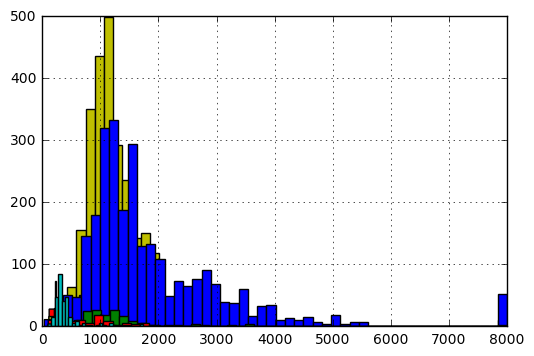

In [47]:
hists = groups.hist(bins=50, alpha=0.2)

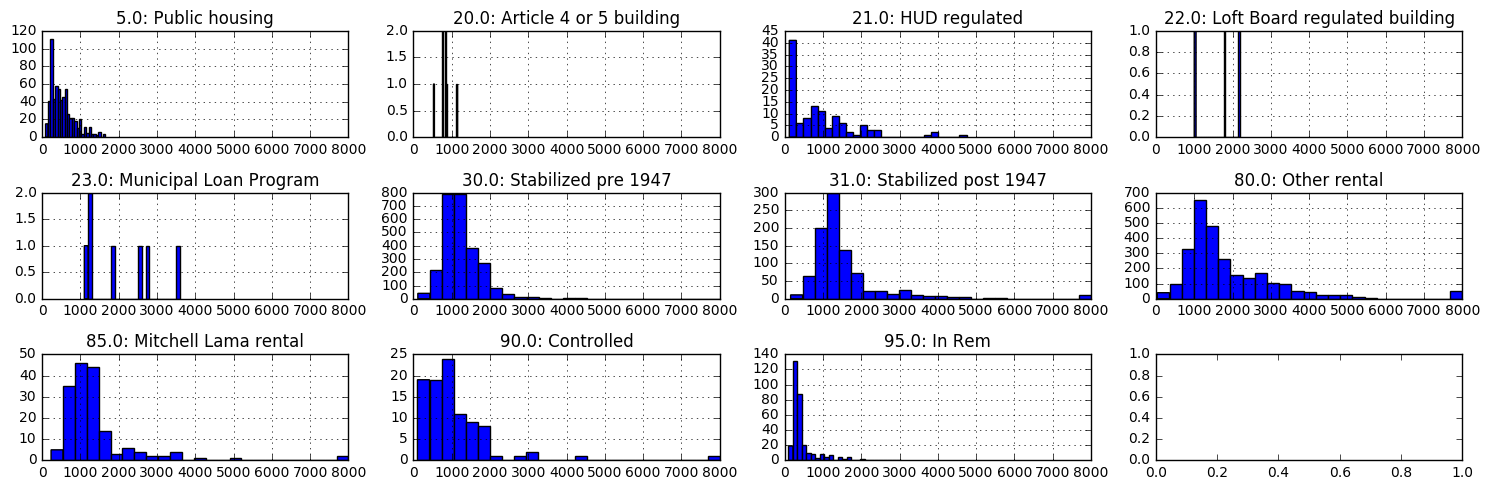

In [48]:
fig, axes = plt.subplots(3, len(groups) // 3 + 1, figsize=(15, 5))
for ax, (val, group) in zip(axes.ravel(), groups):
    group.hist(ax=ax, bins=25)
    ax.set_xlim(0, 8000)
    ax.set_title("{}: {}".format(val, code_dict[val]))

    plt.tight_layout()

### Final model:
Ridge regression technique with alpha value of 10 was used, with an overall model performance of 0.50 R^2 value.